# Seasonal SIRS model with ENSO perturbations
### ENSO perturbations start at beginning of calendar year
* Original SIRS model code created by Wenchang Yang (Baker et al. 2020)
* Modified SIRS code and ENSO perturbations by Maya Chung
    * Generalized to non-specific disease
    * Baseline R0 = 3, seasonal variation in R0 = 0.75
    * Immunity length L = 500 days
    * ENSO kick to R0 = 0.75
* Run for 1000 years before applying interannual ("ENSO") perturbations

Last updated August 19 2024

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.ticker as ticker

#define figure resolution
plt.rcParams['figure.dpi'] = 250

# SIRS model functions

In [3]:
def R0_at_t(R0, t, cycle=False):
    '''R0 as function of t (time) and specific humidity (q).
    q has dims of (n_time, n_grid).'''
    ndays_per_year = 365 # 52x7, to be consistent with Rachel Baker's
    
    if cycle:   # cycle through the first 365 daily specific humidity
        R0t = R0.isel(time=( np.mod(t, ndays_per_year) ).astype(int), drop=True)
    else:
        R0t = R0.isel(time=t.astype(int), drop=True)
    return R0t


In [4]:
def model_SIRS(y, t, R0, L, D):
    '''Normalized version SIRS model from Baker et al., 2020.
    L: immunity length (days)
    D: infection period (days)
    R0 = beta*D
    '''
    ss, ii = y
    dydt = [
        (1-ss-ii)/L - R0*ii*ss/D, 
        R0*ii*ss/D - ii/D
    ]
    return dydt

In [5]:
def run_SIRS(R0=2, L=500, D=5, I0=1e-5, T=10*365, dt=1):
    
    y0 = [1.0-I0, I0]
    t = np.linspace(0, T, int(T/dt)+1)
    sol = odeint(model_SIRS, y0, t, args=(R0, L, D))
    
    da = xr.DataArray(sol, dims=['t', 'si'], coords=[t, ['S/N', 'I/N']])
    da.t.attrs['units'] = 'day'
    
    return da

# run here if desired
# da = run_SIRS()
# da.sel(si='I/N').plot()

In [6]:
def model_climSIRSwy(ss, ii, t, L, D, R0):
    '''SIRS model right hand side from Baker et al., 2020.

    Input:
    -------
        ss: S/N
        ii: I/N
        t: time (units is 'day')
        L: immunity length, 7x66.25(62.5) days for HKU1 (OC43)
        D: infection period, 10 days
        R0 = beta*D
        
    Return:
    --------
        tuple (dsdt, didt)
        dsdt: S/N tendency
        didt: I/N tendency
    '''
    if hasattr(R0, 'time'): # R0 is time-dependent
        #plt.plot(R0.time,R0)
        #print(f'R0 size: {R0.size}')
        _R0 = R0_at_t(R0, t)
        if _R0.ndim < 1:
            _R0 = _R0.item()
    else:
        _R0 = R0
    dsdt = (1-ss-ii)/L - _R0*ii*ss/D
    didt = _R0*ii*ss/D - ii/D

    return dsdt, didt

In [7]:
def rk4_climSIRSwy(ss, ii, t, dt, L, D, R0):
    '''Step change from classic Runge–Kutta (RK4) method for SIRS model of Baker et al., 2020.

    Input:
    -------
        ss: S/N
        ii: I/N
        t: time (units is 'day')
        dt: time step
        L: immunity length
        D: infection period, 10 days
        R0 = beta*D
        
    Return:
    --------
        tuple (dss, dii)
        dss: S/N step increase
        dii: I/N step increase
    '''
    model_climSIRS = model_climSIRSwy
    k1s, k1i = model_climSIRS(ss=ss, ii=ii, t=t, L=L, D=D, R0=R0)
    k2s, k2i = model_climSIRS(ss=ss+k1s*dt/2, ii=ii+k1i*dt/2, t=t+dt/2, L=L, D=D, R0=R0)
    k3s, k3i = model_climSIRS(ss=ss+k2s*dt/2, ii=ii+k2i*dt/2, t=t+dt/2, L=L, D=D, R0=R0)
    k4s, k4i = model_climSIRS(ss=ss+k3s*dt, ii=ii+k3i*dt, t=t+dt, L=L, D=D, R0=R0)
    
    dss = dt*(k1s + 2*k2s + 2*k3s + k4s)/6
    dii = dt*(k1i + 2*k2i + 2*k3i + k4i)/6

    return dss, dii

In [99]:
def run_climSIRSwy(ii0=1e-5, ss0=None, T=10*365, dt=1, L=500, D=5, R0=2, dis=None):
    '''Integrate SIRS model from Baker et al., 2020.

    Input:
    -------
        I0: initial I/N
        T: time stop (start is 1; units is 'day')
        dt: time step
        L: immunity length, 7x66.25(62.5) days for HKU1 (OC43)
        D: infection period, 10 days
        R0 = beta*D
        
    Return:
    --------
        ds: solution for the xclimSIRS model.
    '''
    
    from tqdm.notebook import tqdm
    
    t_vec = np.arange(0, T, dt)
    
    if L is None and dis is not None:
        L = Ldis[dis]
    if hasattr(R0, 'time'): # R0 time-dependent
        zeros = ii0*L*D*R0.isel(time=0, drop=True)*0 # broadcast array by R0.dims[1:]
    else: # R0 time-independent
        zeros = ii0*L*D*R0*0
    # default initial S/N value determined by initial I/N value
    if ss0 is None:
        ss0 = 1 - ii0
    # broadcast initial values by adding zeros
    ii = ii0 + zeros
    ss = ss0 + zeros
    
    ss_vec = [ss,]
    ii_vec = [ii,]
    print('time step (units: day): ', end='')
    for t in tqdm(t_vec[1:]):
#         if np.mod(t, 365) == 0:
#             print(f'365x{t//365}', end='; ')
        dss, dii = rk4_climSIRSwy(ss=ss, ii=ii, t=t, dt=dt, L=L, D=D, R0=R0)
        ss = ss + dss
        ii = ii + dii
        ss_vec.append(ss)
        ii_vec.append(ii)
    print()
    if isinstance(ss, xr.DataArray):
        try:
            da_ss = xr.concat(ss_vec, dim=pd.Index(t_vec, name='t'))
            da_ii = xr.concat(ii_vec, dim=pd.Index(t_vec, name='t'))
        except MemoryError:
            ss_vec = [_ss.expand_dims('dum').chunk({'dum':1}).squeeze() for _ss in ss_vec]
            ii_vec = [_ii.expand_dims('dum').chunk({'dum':1}).squeeze() for _ii in ii_vec]
            da_ss = xr.concat(ss_vec, dim=pd.Index(t_vec, name='t'))
            da_ii = xr.concat(ii_vec, dim=pd.Index(t_vec, name='t'))
    else:
        da_ss = xr.DataArray(ss_vec, dims=['t'], coords=[t_vec])
        da_ii = xr.DataArray(ii_vec, dims=['t'], coords=[t_vec])
    da_ss.attrs['long_name'] = 'S/N'
    da_ii.attrs['long_name'] = 'I/N'
    ds = xr.Dataset(dict(ss=da_ss, ii=da_ii, year=da_ss.t/365))
    ds.t.attrs['units'] = 'day'

    return ds

# ds = run_climSIRSwy()
# ds.ii.assign_coords(t=ds.year).rename(t='year').plot()


## Function to compute attractor
Used for looking at anomalies from attractor

In [61]:
# seasonally-varying R0, without ENSO perturbations
# for seasonal disease model, uses a spinup period = 5 years default
# computes attractor between year 5 to end of timeseries by default

def compute_attractor(SIR, t, spinup_yr=5, yr_end=None):
    # compute the attractor given a range of years to compute over
    # SIR: S, I, or R input for computing attractor
    # spinup_yr: year to start computing attractor
    # t: time in days
    # yr_end: end of year range to compute attractor over (end of timeseries by default)
    
    t_yr = t / 365 # time in years

    SIR_arr = [] # initialize array for S, I, R input
    
    if yr_end == None:
        yr_end = int(np.round(np.max(t/365))) # total number of years

    for iyr in range(yr_end - spinup_yr): # 
        yr0 = spinup_yr + iyr
        cond1 = t_yr >= yr0
        cond2 = t_yr < yr0 + 1

        #t_temp = t_yr[cond1 & cond2]
        SIR_ = SIR[cond1 & cond2]

        if len(SIR_arr) == 0:
            SIR_arr = np.expand_dims(SIR_, axis=0)
        else:
            SIR_ = np.expand_dims(SIR_, axis=0)
            SIR_arr = np.concatenate((SIR_arr, SIR_), axis=0)

    # compute attractor (average) 
    attractor = np.array(SIR_arr).mean(axis=0)

    # Concatenate total number of years
    n = int(np.round(np.max(t/365))) # yr_end - spinup_yr
    # Concatenate the attractor with itself n times
    attractor_timeseries = attractor
    for _ in range(n-1):
        attractor_timeseries = np.concatenate((attractor_timeseries, attractor))

    #plt.plot(t_yr[t_yr >= spinup_yr],attractor_timeseries)
    
    return attractor, attractor_timeseries

## Function to plot susceptible fraction, infected fraction, and recovered fraction, anomalies from attractor, and $R_0$ over time

Includes plotting for ENSO events

In [57]:
def SIRSplot(t,S,I,R,beta_over_time,title,
           Nino_start=None,Nino_end=None,Nina_start=None,Nina_end=None,
           spinup_yr=5, yr_end=None, plot=1):
    
    # computes the attractor and plots if desired
    
    t_yr = t/365
    
    ## Compute the attractor
    S_att, S_att_ts = compute_attractor(S,t,spinup_yr,yr_end)
    I_att, I_att_ts = compute_attractor(I,t,spinup_yr,yr_end)
    R_att, R_att_ts = compute_attractor(R,t,spinup_yr,yr_end)
    print(S_att_ts.size)
    
    attractor = xr.Dataset({
        'S_att': (['t'], S_att_ts),
        'I_att': (['t'], I_att_ts),
        'R_att': (['t'], R_att_ts),},
        coords={'t': t},)
    if plot == 0:
        return attractor
    
    if plot == 1:
        # plot the results
        fig, axs = plt.subplots(3, 1, figsize=(12,8), facecolor='w', sharex=False)

        ax = axs[0]
        ax.plot(t_yr, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t_yr, I, 'r', alpha=0.5, lw=4, label='Infected')
        ax.plot(t_yr, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
        ax.set_ylabel('Fraction of population', fontsize=12)
        ax.set_title(title,fontsize=20)
        ax.set_ylim(0,1.1)

        ax = axs[1]
        # plot the anomaly
        ax.plot(t_yr, S-S_att_ts, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t_yr, I-I_att_ts, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t_yr, R-R_att_ts, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
        ax.set_title('Anomaly from attractor',fontsize=20)
        #ax.set_ylim(-0.4,0.4)

        ax = axs[2]
        ax.plot(beta_over_time.time/365, beta_over_time, 'purple', alpha=0.5, lw=2, label='$R_0(t)$')
        ax.set_ylabel('Transmission rate', fontsize=12)
        ax.set_title('$R_0$ over time')

        # draw rectangles for El Niño, La Niña times
        #import matplotlib.patches as patches
        # Set the aspect ratio of the plot
        #ax.set_aspect('equal')

        for ax in axs.flatten():
            # highlight ENSO events
            y_min = -np.inf
            y_max = np.inf

            if Nino_start != None:
                ax.axvspan(Nino_start/365, Nino_end/365, alpha=0.2, color='red')
            if Nina_start != None:
                ax.axvspan(Nina_start/365, Nina_end/365, alpha=0.2, color='blue')

            # misc. plotting preferences
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
            ax.yaxis.set_tick_params(length=0)
            ax.xaxis.set_tick_params(length=0)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))  # Sets major ticks every n years
            ax.grid(which='major', c='gray', lw=2, ls='--', alpha=0.3, zorder=0)
            legend = ax.legend(fontsize=10)
            legend.get_frame().set_alpha(0.5)
            for spine in ('top', 'right', 'bottom', 'left'):
                ax.spines[spine].set_visible(False)
            ax.set_xlabel('Time [years]', fontsize=12)

        plt.tight_layout()
        #plt.show()
    
        return fig, attractor


# Spin up the SIRS model - 1000 years and save

In [46]:
L = 500 # immunity length (days)
D = 10 # infection period (days)
ii0 = 1e-5 # initial I/N: 1 in 1 million people

# 1000 years spin-up + 30 years
n_years = 1000
T = 365*n_years # time to run over (days)

dt = 1 # timestep (days)

# R0 base is the basic reproduction number in absence of seasonality
R0_base = 3 
R0_amplitude = 0.75 # change in R0 due to seasonality
R0_period = 2 * np.pi

In [47]:
# beta is a function of time (seasonality)
def R0(t): 
    # we use a sin function of time to model seasonal oscillations
    return (R0_base + R0_amplitude * np.sin(R0_period * t / 365)) 

t = np.arange(0, T+dt, dt)
R0_over_time = np.array([R0(time) for time in t])

R0 = xr.DataArray(data=R0_over_time, #R0 = beta*D, scalar, 1-D array or time-dependent n-D DataArray
                  dims=['time'],
                  coords=dict(time=t,))

In [48]:
# run the model
ds = run_climSIRSwy(ii0=ii0, D=D, R0=R0, dt=dt, T=T, L=L)

time step (units: day): 

  0%|          | 0/364999 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Compare different years of the seasonal SIRS model spin-up')

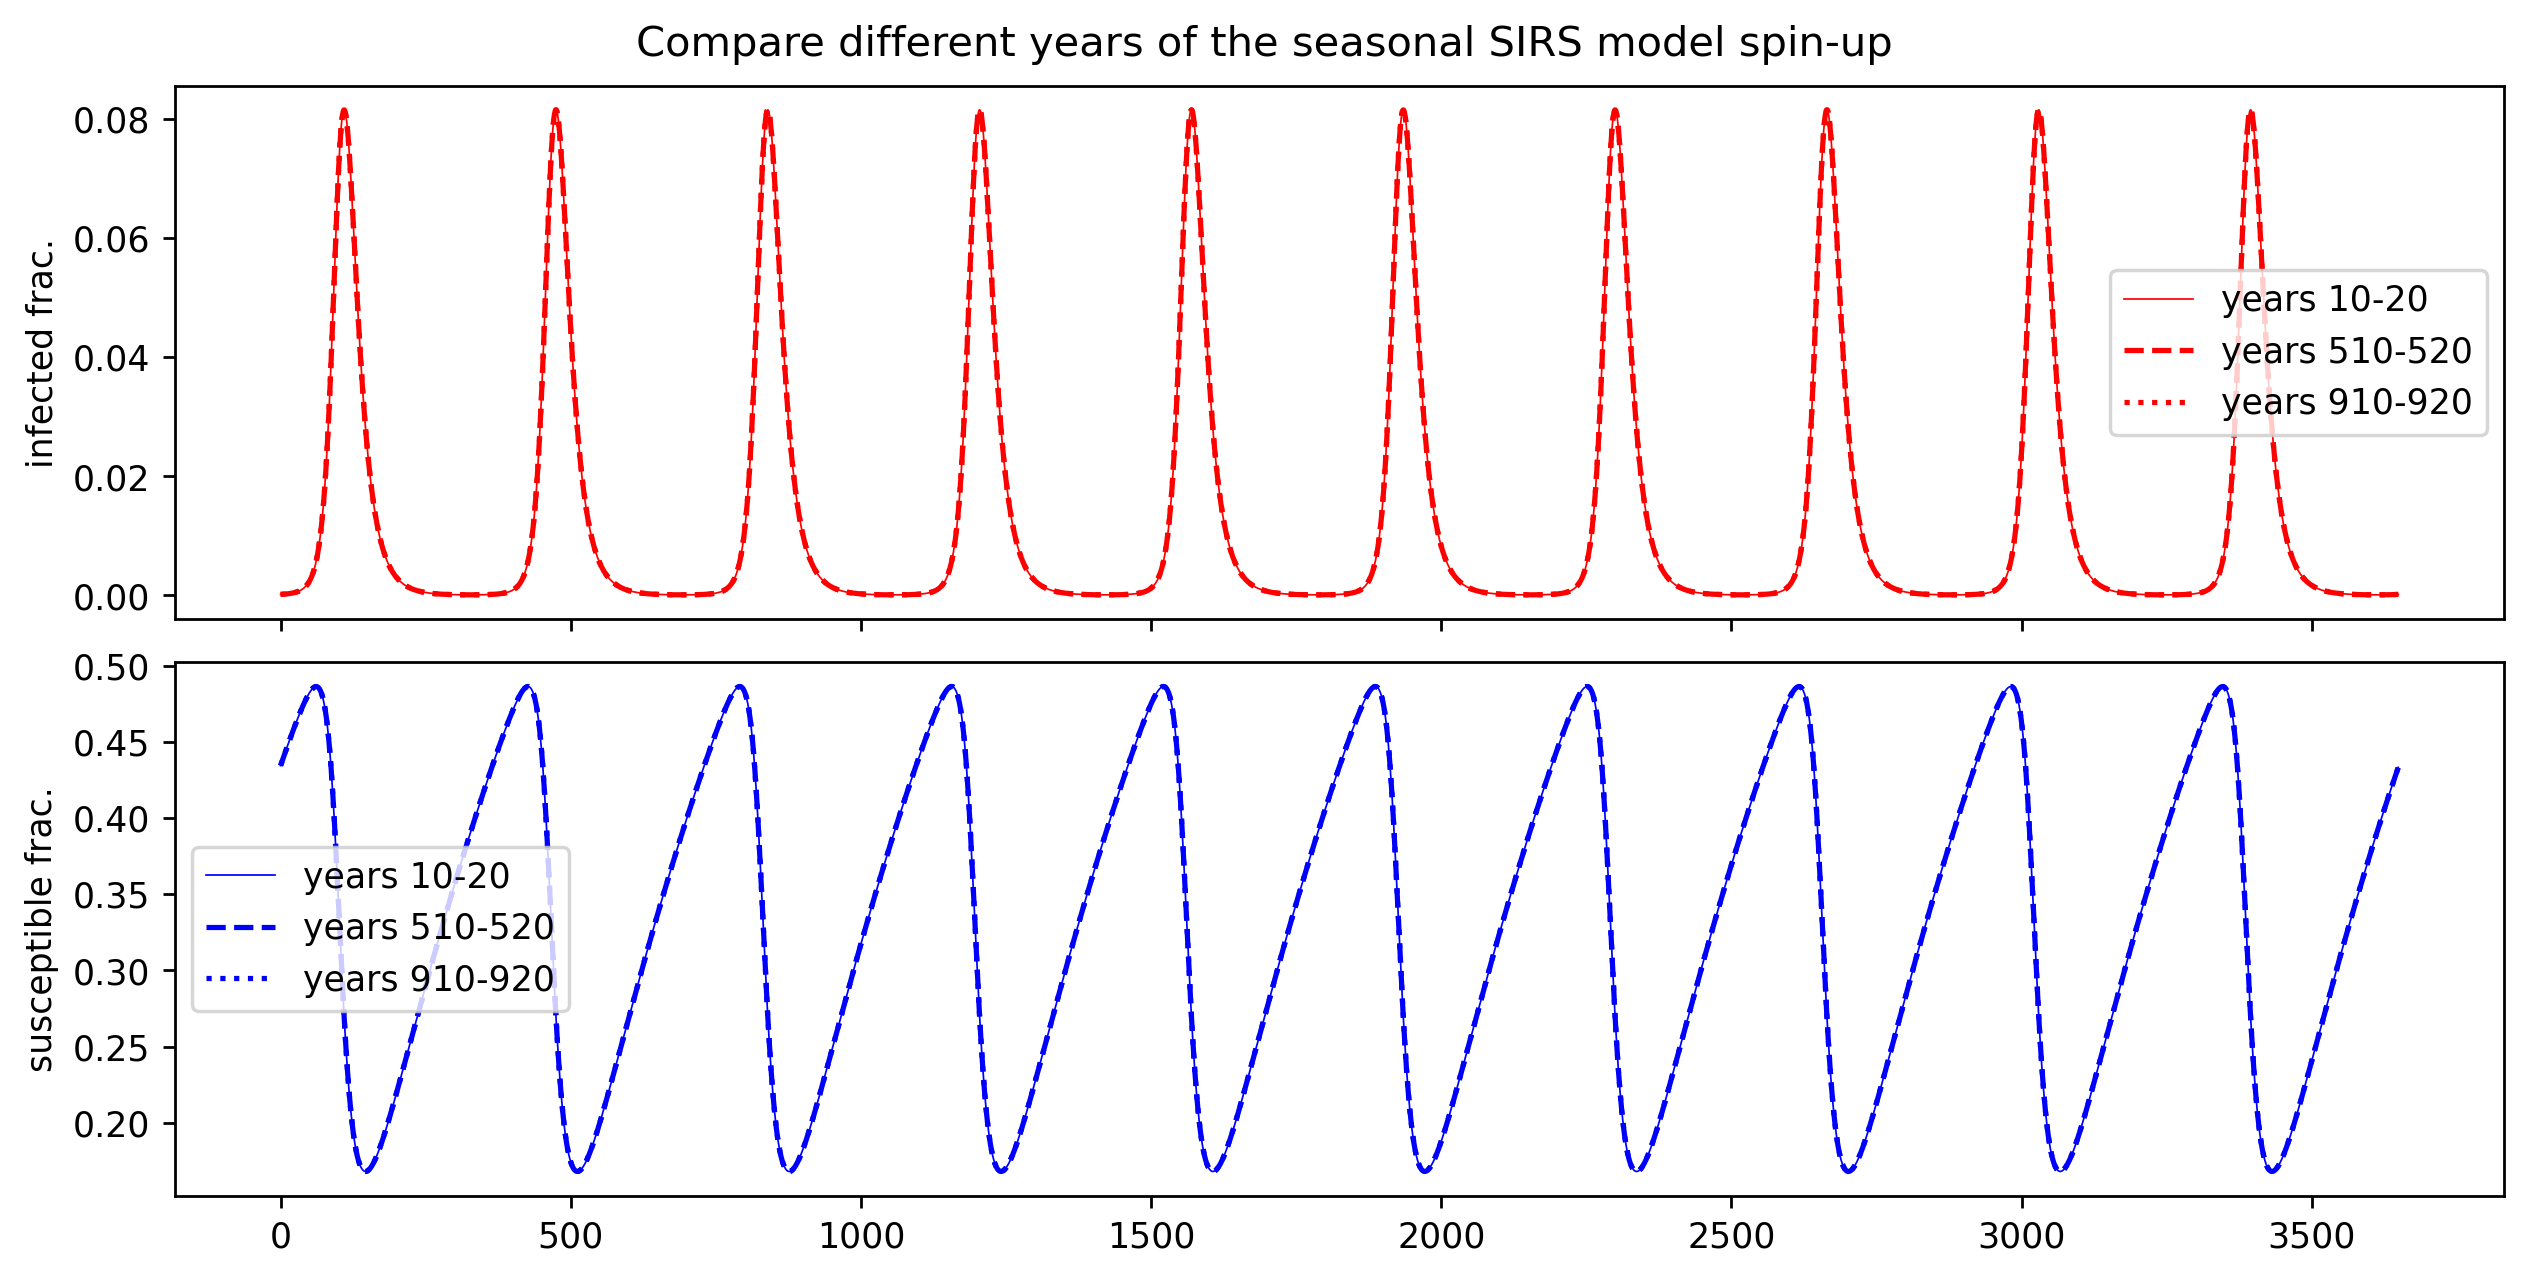

In [55]:
# plot to look at any differences
S = ds.ss
I = ds.ii
R = 1 - S - I

t = np.arange(0,365*10)

fig, ax = plt.subplots(2,1,sharex=True, constrained_layout=True, figsize=(10,5))

ax[0].plot(t,I.isel(t=slice(365*10,365*20)), label='years 10-20', color='r',linewidth=0.5)
ax[0].plot(t,I.isel(t=slice(365*510,365*520)), label='years 510-520', color='r', linestyle='--')
ax[0].plot(t,I.isel(t=slice(365*910,365*920)), label='years 910-920', color='r', linestyle=':')

ax[0].set_ylabel('infected frac.')

ax[1].plot(t,S.isel(t=slice(365*10,365*20)), label='years 10-20', color='b',linewidth=0.5)
ax[1].plot(t,S.isel(t=slice(365*510,365*520)), label='years 510-520', color='b', linestyle='--')
ax[1].plot(t,S.isel(t=slice(365*910,365*920)), label='years 910-920', color='b', linestyle=':')

ax[1].set_ylabel('susceptible frac.')

for iax in ax:
    iax.legend()
    
fig.suptitle('Compare different years of the seasonal SIRS model spin-up')

#fig, attractor = SIRSplot(ds.t,S,I,R,R0,f'SIRS model run')

#attractor.to_netcdf(f'./SIRS_output_final/spinup_{n_years}_R0base{R0_base}_amp{R0_amplitude}_D{D}_standard_attractor.nc')

## save data

In [56]:
# save R0 over time and SIR data

# R0
np.save(f'./SIRS_output_final/spinup_{n_years}_R0base{R0_base}_amp{R0_amplitude}_D{D}_R0standard.npy', R0_over_time)

# S, I, R
ds.to_netcdf(f'./SIRS_output_final/spinup_{n_years}_R0base{R0_base}_amp{R0_amplitude}_D{D}.nc')

In [68]:
S_att, S_att_ts = compute_attractor(S,ds.t,spinup_yr=1000, yr_end=1030)
S_att, S_att_ts

(array([], dtype=float64), array([], dtype=float64))

In [72]:
# compute and save attractor
S = ds.ss
I = ds.ii
R = 1 - S - I

attractor = SIRSplot(ds.t,S,I,R,R0,f'SIRS model run',spinup_yr=900, yr_end=1000, plot=0)

attractor.to_netcdf(f'./SIRS_output_final/spinup_{n_years}_R0base{R0_base}_amp{R0_amplitude}_D{D}_standard_attractor.nc')

365000


# Add a "kick" to $R_0$ to mimic ENSO

In [73]:
#This function applies a kick to R0, saves and plots the data.

def run_SIRS_ENSO(ElNino_start=None,ElNino_end=None,LaNina_start=None,LaNina_end=None,
                  plot=1,savedata=1,
                  spinup_yr=5,yr_end=11,kick=0.75,
                 R0_base=3, R0_amplitude=0.75, R0_period=2*np.pi,
                  L=500, D=10, ii0=1e-5, ss0=None, T=365*30, dt=1,
                  title='SIRS model',expname='EXPERIMENT_NAME', spinupyears=1000):
    
    # ElNino_start, ElNino_end, LaNina_start, and LaNina_end: years of El Niño or La Niña
    # spinupyr and yr_end: time period to compute attractor over (years)
    
    def R0(t):
        # we use a sin function of time to model seasonal oscillations
        R0 = R0_base + R0_amplitude * np.sin(R0_period * t / 365)
        # add a pulse 
        if ElNino_start != None:
            if ElNino_start <= t <= ElNino_end:
                R0 += kick #R0_amplitude/2 * np.sin(2 * np.pi * t / 365)
        if LaNina_start != None:
            if LaNina_start <= t <= LaNina_end:
                R0 -= kick #R0_amplitude/2 * np.sin(2 * np.pi * t / 365)
        return R0 
    
    t = np.arange(0, T+dt, dt)
    
    R0_over_time = np.array([R0(time) for time in t])

    R0 = xr.DataArray(data=R0_over_time, #R0 = beta*D, scalar, 1-D array or time-dependent n-D DataArray
                      dims=['time'],
                      coords=dict(time=t,))
    #print(R0)
    
    ds = run_climSIRSwy(ii0=ii0, ss0=ss0, L=L, D=D, R0=R0, dt=dt, T=T) # run the model
    #print(ds)
    ds['R0'] = ('t',R0.isel(time=slice(0,-1)).data)
    
    S = ds.ss
    I = ds.ii
    R = 1 - S - I
    
    if plot == 0:
        # compute attractor, no plot
        att = SIRSplot(ds.t,S,I,R,R0,f'{title}',ElNino_start,ElNino_end,
                     LaNina_start,LaNina_end,spinup_yr=spinup_yr,yr_end=yr_end, plot=plot)
        
        if savedata == 1:
            print('saving data...')
            ds.to_netcdf(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_{expname}.nc')
            
        return ds, att
    
    if plot == 1:
        # PLOT
        plt.figure(figsize=(10,4))
        plt.plot(ds.year,I)
        plt.ylabel('$I/N$')
        plt.title('Infected fraction')
        plt.ylim(0,0.2)
        
        # computes attractor and plots
        fig, att = SIRSplot(ds.t,S,I,R,R0,f'{title}',ElNino_start,ElNino_end,
                     LaNina_start,LaNina_end,spinup_yr=spinup_yr,yr_end=yr_end, plot=plot)
    
        if savedata == 1:
            print('saving data...')
            ds.to_netcdf(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_{expname}.nc')
            
        return ds, att, fig
        


# Run SIRS model for different ENSO scenarios

In [74]:
kick = 0.75 # size of kick to R0 during ENSO event
T = 365*30 # time to run over (days)

pulseyr = 14 #year for El Niño, La Niña to start

# for computing the attractor
spinup_yr = 1 
yr_end = pulseyr - 4

In [75]:
# load the spun-up data
ds = xr.open_dataset(f'./SIRS_output_final/spinup_{n_years}_R0base{R0_base}_amp{R0_amplitude}_D{D}.nc')
ii0 = ds.ii.isel(t=-1)
ss0 = ds.ss.isel(t=-1)

## standard experiments

In [76]:
# don't plot, just generate the data
plot = 0

##### El Niño #####
ElNino_start = pulseyr*365 
ElNino_end = ElNino_start + 365

ds_Nino, att_Nino = run_SIRS_ENSO(ElNino_start,ElNino_end,None,None,
                                        plot=plot, title='El Niño',
                                         spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                                  ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                      expname='1Nino',spinupyears=n_years)
print('1Nino done')

##### 1 La Niña 1 El Niño #####
LaNina_start = ElNino_start - 365
LaNina_end = ElNino_start - 1

ds_NinaNino, att_NinaNino = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='La Niña followed by El Niño',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                                        ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                              expname='1Nina1Nino',spinupyears=n_years)
print('1Nina1Nino done')

##### 3 La Niña 1 El Niño #####
LaNina_start = ElNino_start - 3*365
LaNina_end = ElNino_start - 1

ds_3Nina1Nino, att_3Nina1Nino = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='3 La Niña followed by 1 El Niño',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                  ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model                            
                                                  expname='3Nina1Nino',spinupyears=n_years)
print('3Nina1Nino done')

##### La Niña #####
LaNina_start = pulseyr*365 
LaNina_end = LaNina_start + 365

ds_Nina, att_Nina = run_SIRS_ENSO(None,None,LaNina_start,LaNina_end,
                                        plot=plot, title='La Niña',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                                     R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                                ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                      expname='1Nina',spinupyears=n_years)
print('1Nina done')

##### 1 El Niño 1 La Niña #####
ElNino_start = LaNina_start - 365
ElNino_end = LaNina_start

ds_NinoNina, att_NinoNina = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='El Niño followed by La Niña',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                                          ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                              expname='1Nino1Nina',spinupyears=n_years)
print('1Nino1Nina done')

##### 3 El Niño 1 La Niña #####
ElNino_start = LaNina_start - 3*365
ElNino_end = LaNina_start - 1

ds_3Nino1Nina, att_3Nino1Nina = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='3 El Niño followed by 1 La Niña',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,T=T,dt=dt,
                        ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                                  expname='3Nino1Nina',spinupyears=n_years)
print('3Nino1Nina done')

time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nino done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nina1Nino done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
3Nina1Nino done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nina done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nino1Nina done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
3Nino1Nina done


# Same ENSO scenarios, but with summer start (6 month shift later)

In [87]:
# All scenarios, but for a shifted start in the ENSO event ("biennial_summerstart")

pulseyr = 14
spinup_yr = 5
yr_end = pulseyr - 4 # before the ENSO perturbations start

# don't plot, just generate the data
plot = 0

##### El Niño #####
ElNino_start = pulseyr*365 + int(365/2) # shift 6 months later
ElNino_end = ElNino_start + 365

ds_Nino, att_Nino = run_SIRS_ENSO(ElNino_start,ElNino_end,None,None,
                                        plot=plot, title='El Niño +6 months',
                                         spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                  T=T,dt=dt,
                                      expname='1Nino_summerstart')
print('1Nino_summerstart done')

##### 1 La Niña 1 El Niño #####
LaNina_start = ElNino_start - 365
LaNina_end = ElNino_start - 1

ds_NinaNino, att_NinaNino = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='La Niña followed by El Niño +6 months',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                          T=T,dt=dt,
                                              expname='1Nina1Nino_summerstart')
print('1Nina1Nino_summerstart done')

##### 3 La Niña 1 El Niño #####
LaNina_start = ElNino_start - 3*365
LaNina_end = ElNino_start - 1

ds_3Nina1Nino, att_3Nina1Nino = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='3 La Niña followed by 1 El Niño +6 months',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                              T=T,dt=dt,
                                                  expname='3Nina1Nino_summerstart')
print('3Nina1Nino_summerstart done')

##### La Niña #####
LaNina_start = pulseyr*365 + int(365/2) # shift 6 months later
LaNina_end = LaNina_start + 365

ds_Nina, att_Nina = run_SIRS_ENSO(None,None,LaNina_start,LaNina_end,
                                        plot=plot, title='La Niña +6 months',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                                     R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                  T=T,dt=dt,
                                      expname='1Nina_summerstart')
print('1Nina_summerstart done')

##### 1 El Niño 1 La Niña #####
ElNino_start = LaNina_start - 365
ElNino_end = LaNina_start

ds_NinoNina, att_NinoNina = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='El Niño followed by La Niña +6 months',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                          T=T,dt=dt,
                                              expname='1Nino1Nina_summerstart')
print('1Nino1Nina_summerstart done')

##### 3 El Niño 1 La Niña #####
ElNino_start = LaNina_start - 3*365
ElNino_end = LaNina_start - 1

ds_3Nino1Nina, att_3Nino1Nina = run_SIRS_ENSO(ElNino_start,ElNino_end,LaNina_start,LaNina_end,
                                               plot=plot, title='3 El Niño followed by 1 La Niña',
                                      spinup_yr=spinup_yr,yr_end=yr_end,kick=kick,
                 R0_base=R0_base,R0_amplitude=R0_amplitude,R0_period=R0_period,
                                       L=L, D=D,ii0=ii0, ss0=ss0, # use infected and susceptible initial conditions from spun-up model
                                              T=T,dt=dt,
                                                  expname='3Nino1Nina_summerstart')
print('3Nino1Nina_summerstart done')

time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nino_summerstart done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nina1Nino_summerstart done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
3Nina1Nino_summerstart done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nina_summerstart done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
1Nino1Nina_summerstart done
time step (units: day): 

  0%|          | 0/10949 [00:00<?, ?it/s]


10950
saving data...
3Nino1Nina_summerstart done


# Load data and plot the SIRS model output (start from here if data already generated)

In [91]:
# specify the relevant values to retrieve the data

#L = 500 # immunity length
D = 10 # infection period
R0_base = 3 
R0_amplitude = 0.75 
kick = 0.75

spinupyears = 1000

In [92]:
# Load data if needed

# standard R0
R0_over_time = np.load(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_D{D}_R0standard.npy')

# ENSO
ds_Nino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino.nc')
ds_Nina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina.nc')
ds_NinoNina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina.nc')
ds_NinaNino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino.nc')
ds_3Nino1Nina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina.nc')
ds_3Nina1Nino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino.nc')

In [93]:
# Load attractor
attractor = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_D{D}_standard_attractor.nc')

t_yr = ds_Nino.t/365
n_t = np.size(t_yr)

attractor = attractor.isel(t=slice(0,n_t))

# plot all together for Jan 1 ENSO event timing

In [94]:
ENSOyr = 14

Text(0.53, 0.98, 'Seasonal SIRS model')

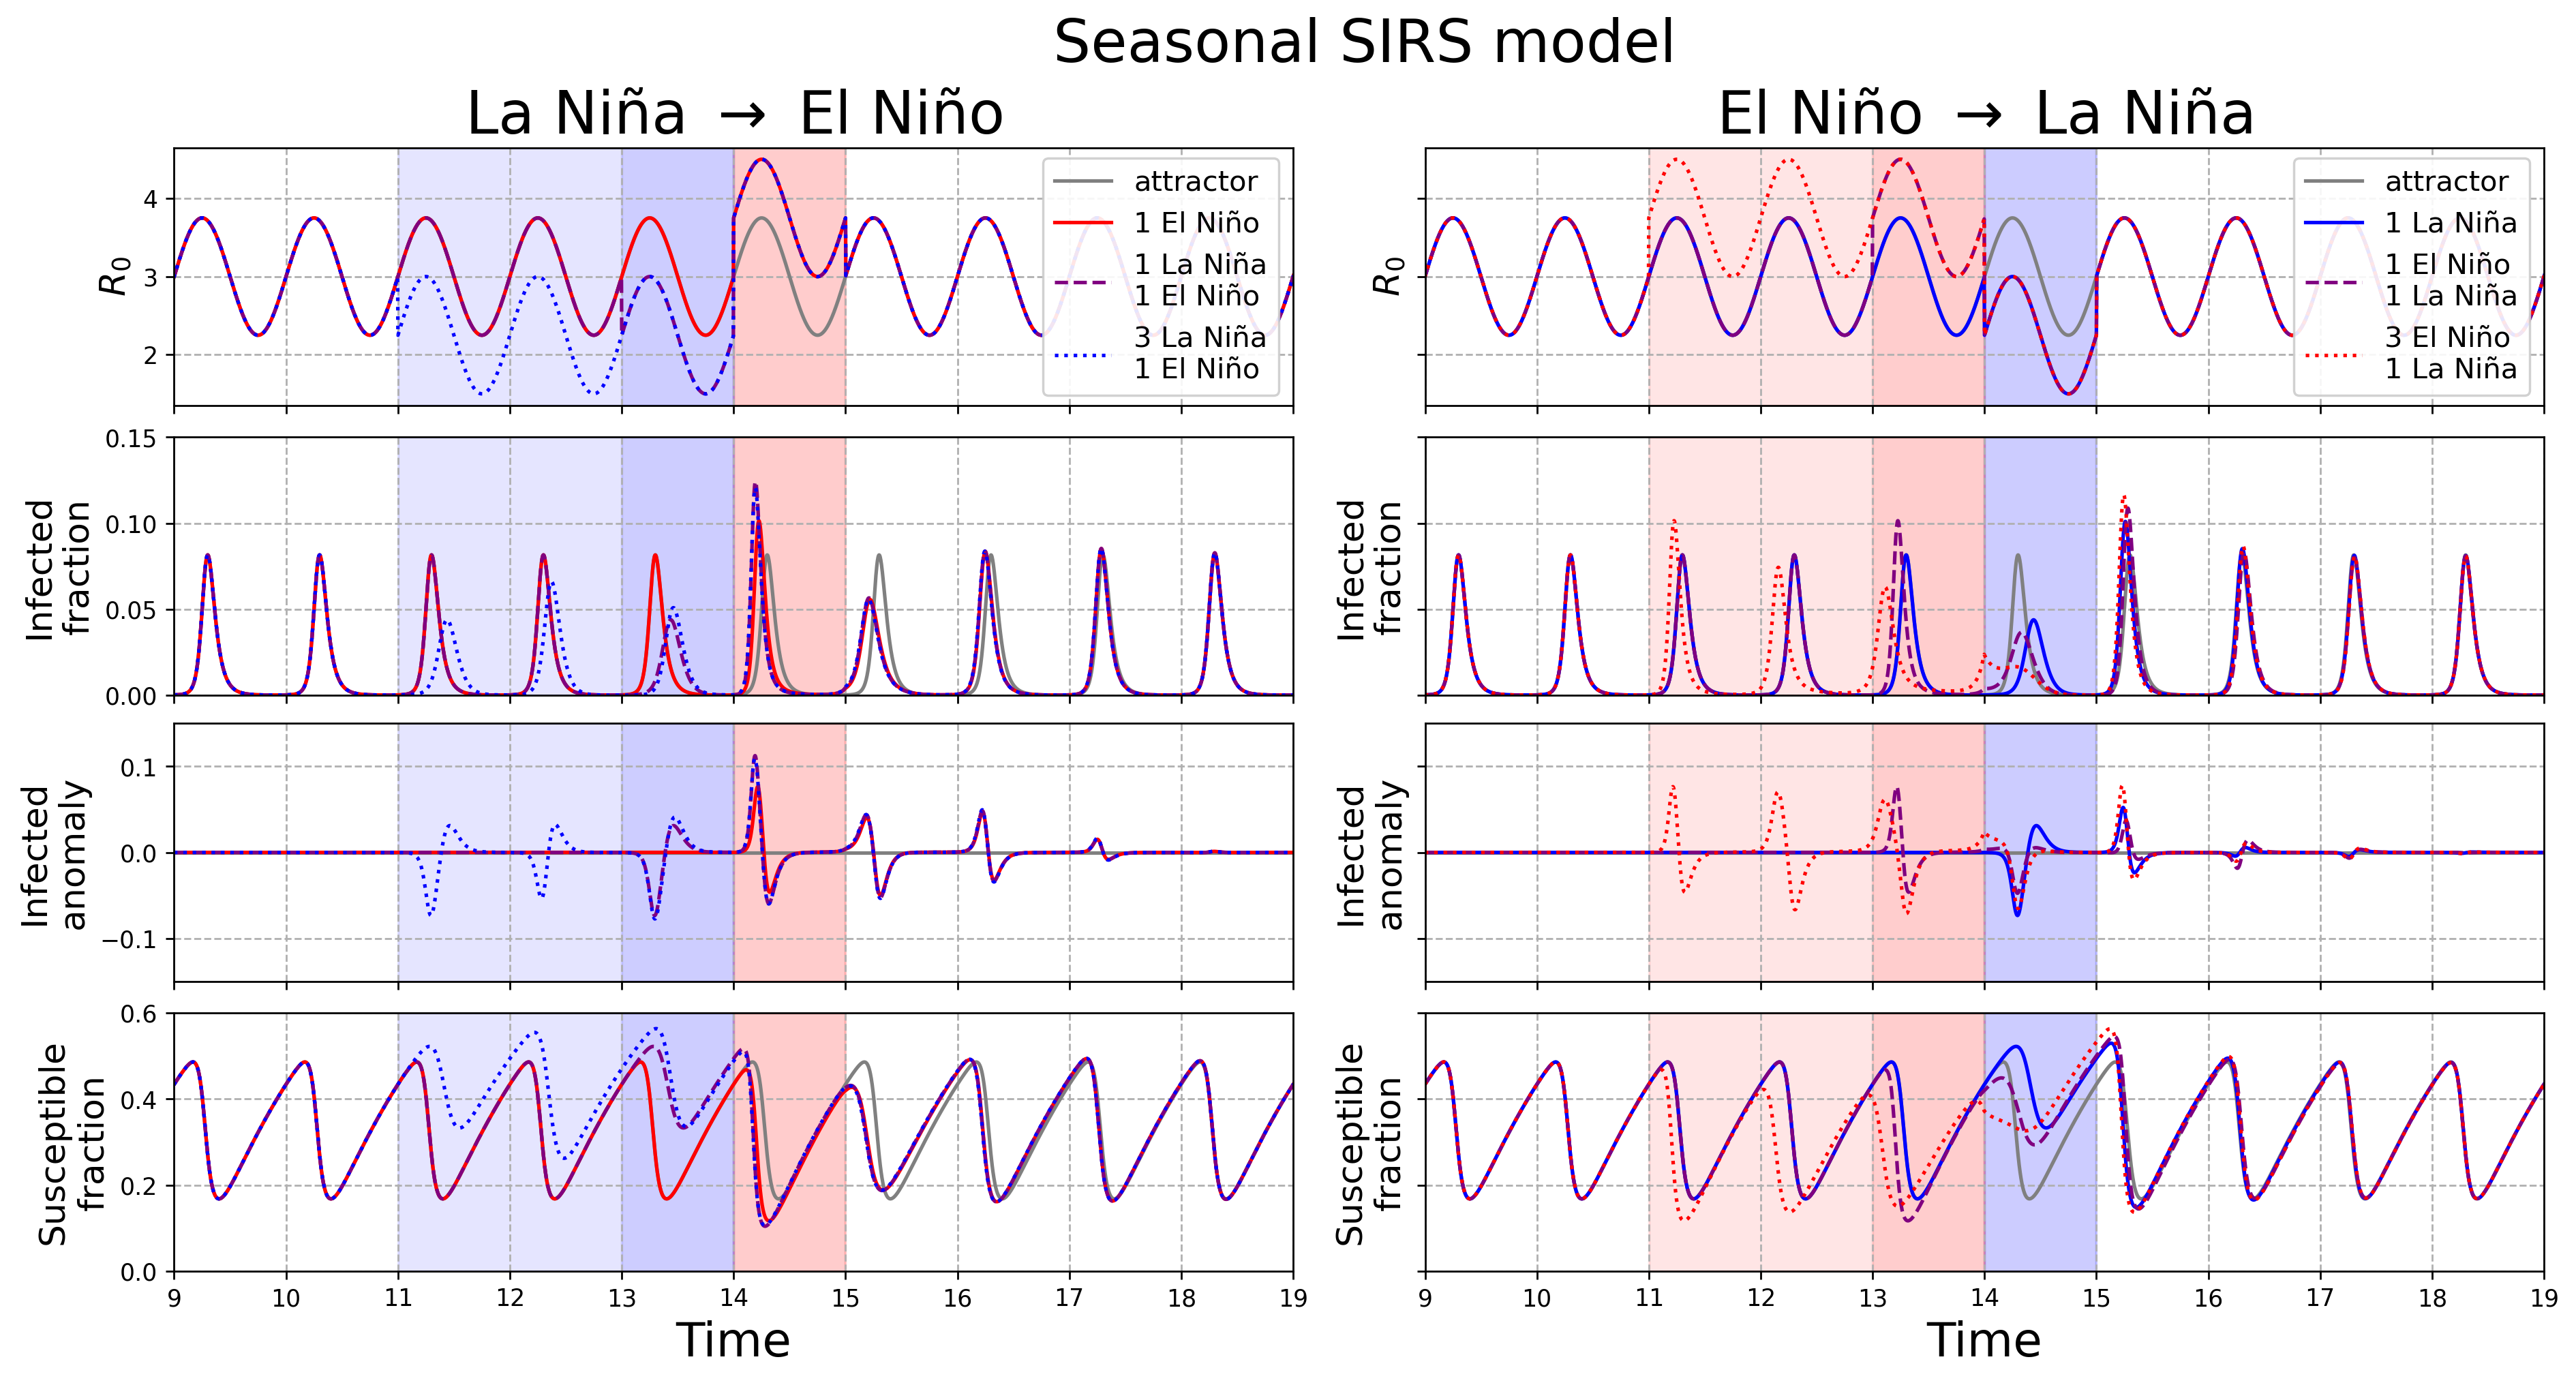

In [95]:
# effect of El Niño vs. El Niño preceded by La Niña
# 
fig, ax = plt.subplots(4,2,constrained_layout=True,figsize=(15,8),sharex=True,sharey='row')

t_yr = ds_Nino.t/365

########## La Niña --> El Niño ##########

# attractor #
ax[0,0].plot(t_yr,R0_over_time[0:n_t],linestyle='-',color='gray',label='attractor')    
ax[1,0].plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor')
ax[3,0].plot(t_yr,attractor.S_att,linestyle='-',color='gray',label='attractor')

# R0 #
ax[0,0].plot(t_yr,ds_Nino.R0,color='r',label='1 El Niño')
ax[0,0].set_ylabel('$R_0$',fontsize=15)
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Sets major ticks every n years

# infected fraction #
ax[1,0].plot(t_yr,ds_Nino.ii,color='r',label='1 El Niño')
ax[1,0].set_ylabel('Infected\nfraction',fontsize=15)
ax[1,0].set_ylim(0,0.15)

# infection anomaly from attractor #
ax[2,0].axhline(0,color='gray')
ax[2,0].plot(t_yr,ds_Nino.ii-attractor.I_att,color='r',label='1 El Niño')
ax[2,0].set_ylabel('Infected\nanomaly',fontsize=15)
ax[2,0].set_ylim(-0.15,0.15)

ax[3,0].plot(t_yr,ds_Nino.ss,color='r',label='1 El Niño')
ax[3,0].set_ylabel('Susceptible\nfraction',fontsize=15)
ax[3,0].set_ylim(0,0.6)
    
# 1 La Niña 1 El Niño #
ax[0,0].plot(t_yr,ds_NinaNino.R0,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[1,0].plot(t_yr,ds_NinaNino.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[2,0].plot(t_yr,ds_NinaNino.ii-attractor.I_att,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[3,0].plot(t_yr,ds_NinaNino.ss,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')

ax[0,0].plot(t_yr,ds_3Nina1Nino.R0,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[1,0].plot(t_yr,ds_3Nina1Nino.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[2,0].plot(t_yr,ds_3Nina1Nino.ii-attractor.I_att,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[3,0].plot(t_yr,ds_3Nina1Nino.ss,linestyle=':',color='b',label='3 La Niña\n1 El Niño')

ax[0,0].legend(fontsize=12,loc='center right',framealpha=0.9)#, bbox_to_anchor=(-0.2, 0.5))   
ax[0,0].set_title(r'La Niña $\rightarrow$ El Niño',fontsize=25)
ax[3,0].set_xlabel('Time',fontsize=20)

for ii in range(4):
    axis = ax[ii,0]
    axis.grid(linestyle='--')
    axis.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='red')
    axis.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='b') 
    axis.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='b')
    axis.set_xlim(9,19)

########## El Niño --> La Niña ##########

# attractor 
ax[0,1].plot(t_yr,R0_over_time[0:n_t],linestyle='-',color='gray',label='attractor')    
ax[1,1].plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor')
ax[3,1].plot(t_yr,attractor.S_att,linestyle='-',color='gray',label='attractor')
# 1 La Niña
# R0
ax[0,1].plot(t_yr,ds_Nina.R0,color='b',label='1 La Niña')
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Sets major ticks every n years
# infected fraction
ax[1,1].plot(t_yr,ds_Nina.ii,color='b',label='1 La Niña')
ax[1,1].set_ylim(0,0.15)
# infection anomaly from attractor #
ax[2,1].axhline(0,color='gray')
ax[2,1].plot(t_yr,ds_Nina.ii-attractor.I_att,color='b',label='1 La Niña')
ax[2,1].set_ylim(-0.15,0.15)
# susceptible fraction
ax[3,1].plot(t_yr,ds_Nina.ss,color='b',label='1 La Niña')
ax[3,1].set_ylim(0,0.6)

ax[0,1].set_ylabel('$R_0$',fontsize=15)
ax[1,1].set_ylabel('Infected\nfraction',fontsize=15)
ax[2,1].set_ylabel('Infected\nanomaly',fontsize=15)
ax[3,1].set_ylabel('Susceptible\nfraction',fontsize=15)

# 1 El Niño 1 La Niña
ax[0,1].plot(t_yr,ds_NinoNina.R0,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[1,1].plot(t_yr,ds_NinoNina.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[2,1].plot(t_yr,ds_NinoNina.ii-attractor.I_att,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[3,1].plot(t_yr,ds_NinoNina.ss,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')

# 3 El Niño 1 La Niña
ax[0,1].plot(t_yr,ds_3Nino1Nina.R0,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[1,1].plot(t_yr,ds_3Nino1Nina.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[2,1].plot(t_yr,ds_3Nino1Nina.ii-attractor.I_att,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[3,1].plot(t_yr,ds_3Nino1Nina.ss,linestyle=':',color='r',label='3 El Niño\n1 La Niña')

ax[0,1].legend(fontsize=12,loc='center right',framealpha=0.9)#, bbox_to_anchor=(-0.2, 0.5))   

ax[0,1].set_title(r'El Niño $\rightarrow$ La Niña',fontsize=25)
ax[3,1].set_xlabel('Time',fontsize=20)
for ii in range(4):
    axis = ax[ii,1]
    axis.grid(linestyle='--')
    axis.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='b')
    axis.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='r') 
    axis.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='r')
    axis.set_xlim(9,19)

fig.suptitle('Seasonal SIRS model',fontsize=25, x=0.53) # adjust horizontal position of suptitle 

# Plot for +6 month shifted experiments

In [96]:
# ENSO
ds_Nino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino_summerstart.nc')
ds_Nina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina_summerstart.nc')
ds_NinoNina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina_summerstart.nc')
ds_NinaNino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino_summerstart.nc')
ds_3Nino1Nina = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina_summerstart.nc')
ds_3Nina1Nino = xr.open_dataset(f'./SIRS_output_final/spinup_{spinupyears}_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino_summerstart.nc')

In [97]:
ENSOyr = 14.5

Text(0.53, 0.98, 'Seasonal SIRS model +6 months')

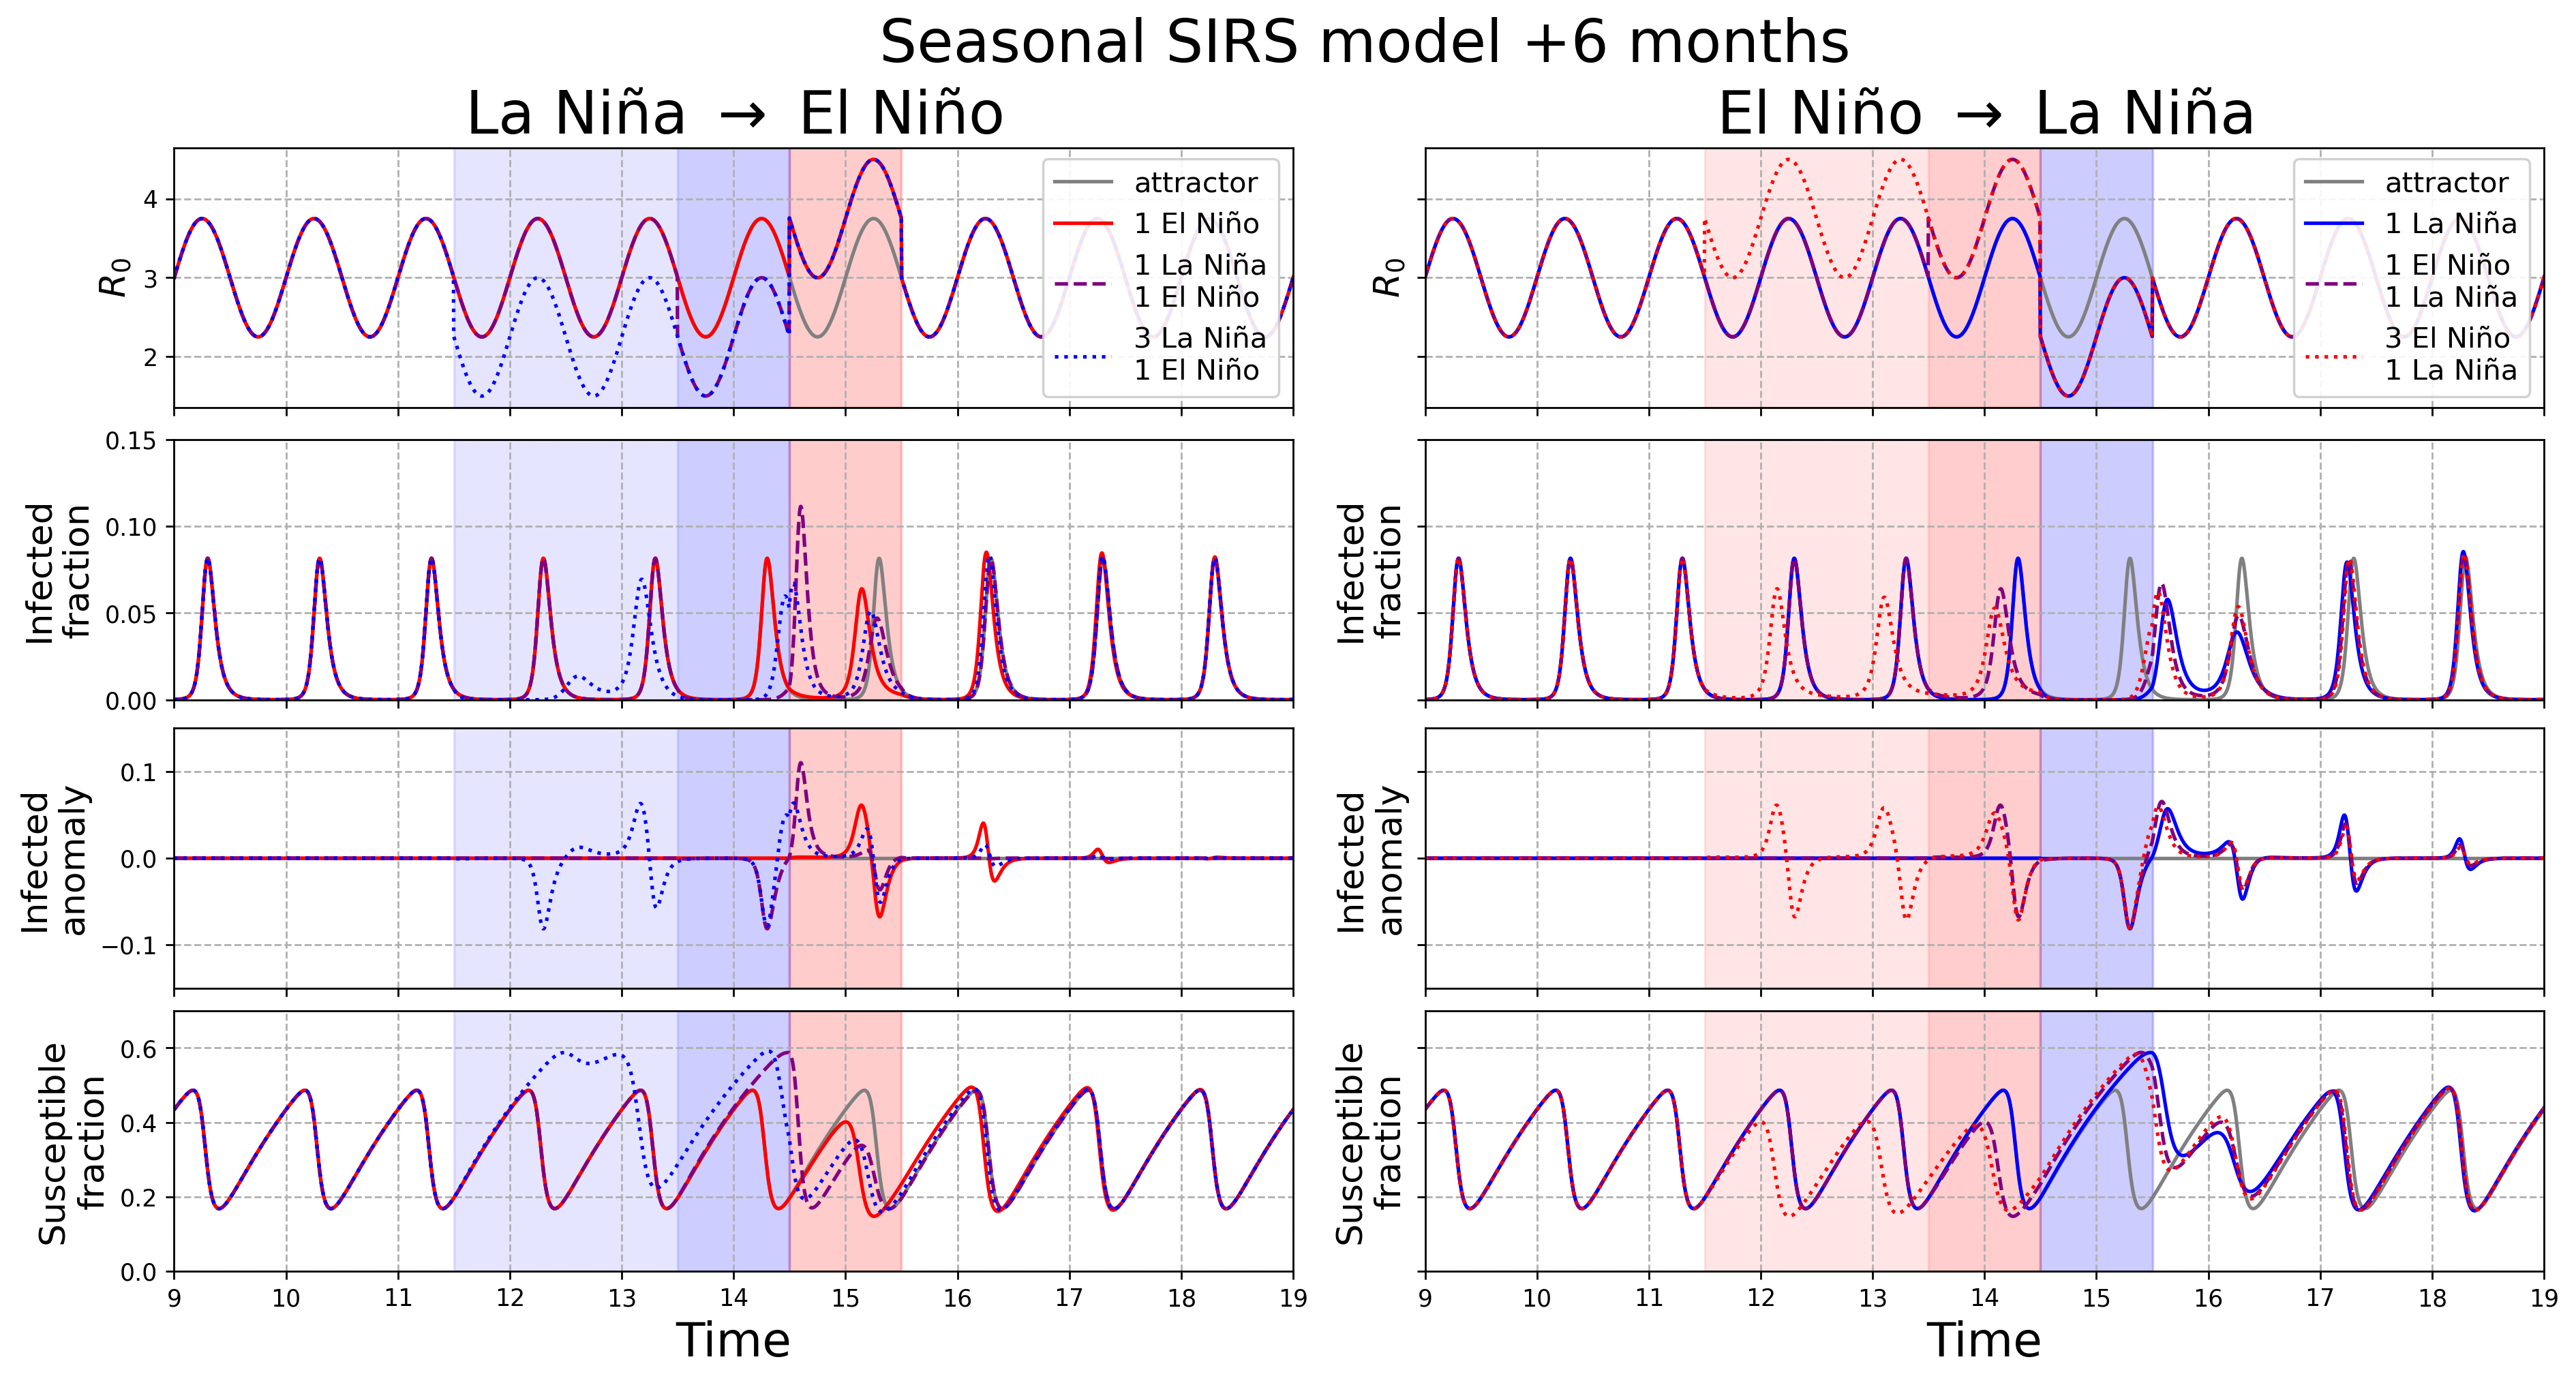

In [98]:
# effect of El Niño vs. El Niño preceded by La Niña
# 
fig, ax = plt.subplots(4,2,constrained_layout=True,figsize=(15,8),sharex=True,sharey='row')

t_yr = ds_Nino.t/365

########## La Niña --> El Niño ##########

# attractor #
ax[0,0].plot(t_yr,R0_over_time[0:n_t],linestyle='-',color='gray',label='attractor')    
ax[1,0].plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor')
ax[3,0].plot(t_yr,attractor.S_att,linestyle='-',color='gray',label='attractor')

# R0 #
ax[0,0].plot(t_yr,ds_Nino.R0,color='r',label='1 El Niño')
ax[0,0].set_ylabel('$R_0$',fontsize=15)
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Sets major ticks every n years

# infected fraction #
ax[1,0].plot(t_yr,ds_Nino.ii,color='r',label='1 El Niño')
ax[1,0].set_ylabel('Infected\nfraction',fontsize=15)
ax[1,0].set_ylim(0,0.15)

# infection anomaly from attractor #
ax[2,0].axhline(0,color='gray')
ax[2,0].plot(t_yr,ds_Nino.ii-attractor.I_att,color='r',label='1 El Niño')
ax[2,0].set_ylabel('Infected\nanomaly',fontsize=15)
ax[2,0].set_ylim(-0.15,0.15)

ax[3,0].plot(t_yr,ds_Nino.ss,color='r',label='1 El Niño')
ax[3,0].set_ylabel('Susceptible\nfraction',fontsize=15)
ax[3,0].set_ylim(0,0.6)
    
# 1 La Niña 1 El Niño #
ax[0,0].plot(t_yr,ds_NinaNino.R0,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[1,0].plot(t_yr,ds_NinaNino.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[2,0].plot(t_yr,ds_NinaNino.ii-attractor.I_att,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')
ax[3,0].plot(t_yr,ds_NinaNino.ss,linestyle='--',color='purple',label='1 La Niña\n1 El Niño')

ax[0,0].plot(t_yr,ds_3Nina1Nino.R0,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[1,0].plot(t_yr,ds_3Nina1Nino.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[2,0].plot(t_yr,ds_3Nina1Nino.ii-attractor.I_att,linestyle=':',color='b',label='3 La Niña\n1 El Niño')
ax[3,0].plot(t_yr,ds_3Nina1Nino.ss,linestyle=':',color='b',label='3 La Niña\n1 El Niño')

ax[0,0].legend(fontsize=12,loc='center right',framealpha=0.9)#, bbox_to_anchor=(-0.2, 0.5))   
ax[0,0].set_title(r'La Niña $\rightarrow$ El Niño',fontsize=25)
ax[3,0].set_xlabel('Time',fontsize=20)

for ii in range(4):
    axis = ax[ii,0]
    axis.grid(linestyle='--')
    axis.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='red')
    axis.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='b') 
    axis.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='b')
    axis.set_xlim(9,19)

########## El Niño --> La Niña ##########

# attractor 
ax[0,1].plot(t_yr,R0_over_time[0:n_t],linestyle='-',color='gray',label='attractor')    
ax[1,1].plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor')
ax[3,1].plot(t_yr,attractor.S_att,linestyle='-',color='gray',label='attractor')
# 1 La Niña
# R0
ax[0,1].plot(t_yr,ds_Nina.R0,color='b',label='1 La Niña')
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Sets major ticks every n years
# infected fraction
ax[1,1].plot(t_yr,ds_Nina.ii,color='b',label='1 La Niña')
ax[1,1].set_ylim(0,0.15)
# infection anomaly from attractor #
ax[2,1].axhline(0,color='gray')
ax[2,1].plot(t_yr,ds_Nina.ii-attractor.I_att,color='b',label='1 La Niña')
ax[2,1].set_ylim(-0.15,0.15)
# susceptible fraction
ax[3,1].plot(t_yr,ds_Nina.ss,color='b',label='1 La Niña')
ax[3,1].set_ylim(0,0.7)

ax[0,1].set_ylabel('$R_0$',fontsize=15)
ax[1,1].set_ylabel('Infected\nfraction',fontsize=15)
ax[2,1].set_ylabel('Infected\nanomaly',fontsize=15)
ax[3,1].set_ylabel('Susceptible\nfraction',fontsize=15)

# 1 El Niño 1 La Niña
ax[0,1].plot(t_yr,ds_NinoNina.R0,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[1,1].plot(t_yr,ds_NinoNina.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[2,1].plot(t_yr,ds_NinoNina.ii-attractor.I_att,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')
ax[3,1].plot(t_yr,ds_NinoNina.ss,linestyle='--',color='purple',label='1 El Niño\n1 La Niña')

# 3 El Niño 1 La Niña
ax[0,1].plot(t_yr,ds_3Nino1Nina.R0,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[1,1].plot(t_yr,ds_3Nino1Nina.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[2,1].plot(t_yr,ds_3Nino1Nina.ii-attractor.I_att,linestyle=':',color='r',label='3 El Niño\n1 La Niña')
ax[3,1].plot(t_yr,ds_3Nino1Nina.ss,linestyle=':',color='r',label='3 El Niño\n1 La Niña')

ax[0,1].legend(fontsize=12,loc='center right',framealpha=0.9)#, bbox_to_anchor=(-0.2, 0.5))   

ax[0,1].set_title(r'El Niño $\rightarrow$ La Niña',fontsize=25)
ax[3,1].set_xlabel('Time',fontsize=20)
for ii in range(4):
    axis = ax[ii,1]
    axis.grid(linestyle='--')
    axis.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='b')
    axis.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='r') 
    axis.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='r')
    axis.set_xlim(9,19)

fig.suptitle('Seasonal SIRS model +6 months',fontsize=25, x=0.53) # adjust horizontal position of suptitle 